This notebook is used to check the performance of multiple missing data imputation performed by advanced neural network models, on a HAD dataset.

In [209]:
import pandas as pd
import numpy as np
import copy
import os
import sys

# Add the parent directory to the system path
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)

RANDOM_STATE = 404

In [210]:
df = pd.read_csv('../data/HAD.csv')
df.head()

AGE  AGE_MISSING  SEX_F  NIHSS_BL  NIHSS_BL_MISSING  SYS_BLOOD_PRESSURE  \
0   70            0      0         3                 0                  -1   
1   55            0      0         6                 0                 142   
2   73            0      0         3                 0                 170   
3   81            0      0        10                 0                  -1   
4   81            0      1        11                 0                  -1   

   SYS_BLOOD_PRESSURE_MISSING  PREV_MRS  PREV_MRS_MISSING  ORAL_ANTICOAGULANT  \
0                           1         0                 0                   0   
1                           0         3                 0                   0   
2                           0         0                 0                   1   
3                           1         0                 0                   0   
4                           1         0                 0                   0   

   ...  ONSET_TO_ADMISSION  ONSET_TO_ADMISSION_MISSING  ONSET_TO_IMAGING  \
0  ...                  64                           0                96   
1  ...                  38                           0               104   
2  ...                  -1                           1                -1   
3  ...                  69                           0                90   
4  ...                  98                           0               110   

   ONSET_TO_IMAGING_MISSING  ONSET_TO_TPA  ONSET_TO_TPA_MISSING  \
0                         0           180                     0   
1                         0           165                     0   
2                         1            -1                     1   
3                         0           115                     0   
4                         0           120                     0   

   ONSET_TO_GROIN  ONSET_TO_GROIN_MISSING  MRS_90  MRS_90_DICHO  
0              -1                       1       0             0  
1              -1                       1       4             1  
2              -1                       1       2             0  
3              -1                       1       3             1  
4              -1                       1       0             0  

[5 rows x 42 columns]

In [211]:
# Create an empty dictionary to store the results after each method
results_dict = {}

# Set default number of samples
default_number_of_samples = 10

## Data manipulation

#### Target feature

In [212]:
from sklearn.preprocessing import LabelEncoder

target_feature = 'MRS_90'
y_raw = df.filter([target_feature])
y = LabelEncoder().fit_transform(y_raw.values.ravel())
df = df.drop(columns=['MRS_90', 'MRS_90_DICHO'], axis=1)

#### Distinguishing between categorical and numeric features

In [213]:
# Need to distinguish between categorical and numerical features for further approximation

# List to store indices of columns with categorical values
columns_with_categorical_values = []

def identify_categorical_columns(df):
    for index in range(len(df.columns)):
        # Get unique values in current column
        unique_values = df.iloc[:, index].unique()
        # Check if number of unique values is less than or equal to 15
        # and if column does not end with '_MISSING'
        if len(unique_values) <= 15 and not df.columns[index].endswith('_MISSING'):
            # Append column index to list
            columns_with_categorical_values.append(index)
    # Return list of columns with categorical values
    return columns_with_categorical_values

# Call the function and store the result
columns_with_categorical_values = identify_categorical_columns(df)

#### Standardization

In [214]:
from dill import load

scalerFile = "..\helpers\predictive_models\HAD_scaler.pkl"

with open(scalerFile, "rb") as f:
    scaler = load(f)

df_scaled = scaler.preprocess_clinical_data(np.asarray(df, dtype=float))
X = pd.DataFrame(df_scaled, columns=df.columns)

X.head(5)

AGE  AGE_MISSING  SEX_F  NIHSS_BL  NIHSS_BL_MISSING  \
0  0.509804          0.0    0.0  0.071429               0.0   
1  0.362745          0.0    0.0  0.142857               0.0   
2  0.539216          0.0    0.0  0.071429               0.0   
3  0.617647          0.0    0.0  0.238095               0.0   
4  0.617647          0.0    1.0  0.261905               0.0   

   SYS_BLOOD_PRESSURE  SYS_BLOOD_PRESSURE_MISSING  PREV_MRS  PREV_MRS_MISSING  \
0              -1.000                         1.0       0.0               0.0   
1               0.368                         0.0       0.6               0.0   
2               0.480                         0.0       0.0               0.0   
3              -1.000                         1.0       0.0               0.0   
4              -1.000                         1.0       0.0               0.0   

   ORAL_ANTICOAGULANT  ...  CTA_CS  CTA_CS_MISSING  ONSET_TO_ADMISSION  \
0                 0.0  ...    -1.0             1.0            0.044444   
1                 0.0  ...    -1.0             1.0            0.026389   
2                 1.0  ...    -1.0             1.0           -1.000000   
3                 0.0  ...    -1.0             1.0            0.047917   
4                 0.0  ...    -1.0             1.0            0.068056   

   ONSET_TO_ADMISSION_MISSING  ONSET_TO_IMAGING  ONSET_TO_IMAGING_MISSING  \
0                         0.0          0.066667                       0.0   
1                         0.0          0.072222                       0.0   
2                         1.0         -1.000000                       1.0   
3                         0.0          0.062500                       0.0   
4                         0.0          0.076389                       0.0   

   ONSET_TO_TPA  ONSET_TO_TPA_MISSING  ONSET_TO_GROIN  ONSET_TO_GROIN_MISSING  
0      0.125000                   0.0            -1.0                     1.0  
1      0.114583                   0.0            -1.0                     1.0  
2     -1.000000                   1.0            -1.0                     1.0  
3      0.079861                   0.0            -1.0                     1.0  
4      0.083333                   0.0            -1.0                     1.0  

[5 rows x 40 columns]

In [215]:
# Warning is given while imputing missing values in 'SERUM_GLUCOSE' and 'VALV_HEART' columns due to missing all values thus they are removed, only to be readded for classification
columns_names_to_add_back_for_classification = ['SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART']
columns_to_add_back_for_classification = X[columns_names_to_add_back_for_classification]
order_of_columns = list(X.columns)

X = X.drop(columns=columns_names_to_add_back_for_classification, axis=1)

In [216]:
X.describe()

AGE  AGE_MISSING       SEX_F    NIHSS_BL  NIHSS_BL_MISSING  \
count  944.000000   944.000000  944.000000  944.000000        944.000000   
mean     0.503282     0.004237    0.452331    0.204802          0.032839   
std      0.170349     0.064991    0.497986    0.296881          0.178309   
min     -1.000000     0.000000    0.000000   -1.000000          0.000000   
25%      0.421569     0.000000    0.000000    0.071429          0.000000   
50%      0.519608     0.000000    0.000000    0.166667          0.000000   
75%      0.617647     0.000000    1.000000    0.404762          0.000000   
max      0.803922     1.000000    1.000000    0.857143          1.000000   

       SYS_BLOOD_PRESSURE  SYS_BLOOD_PRESSURE_MISSING    PREV_MRS  \
count          944.000000                  944.000000  944.000000   
mean            -0.421110                    0.586864    0.135381   
std              0.693467                    0.492658    0.328140   
min             -1.000000                    0.000000   -1.000000   
25%             -1.000000                    0.000000    0.000000   
50%             -1.000000                    1.000000    0.000000   
75%              0.368000                    1.000000    0.400000   
max              0.716000                    1.000000    1.000000   

       PREV_MRS_MISSING  ORAL_ANTICOAGULANT  ...      CTA_CS  CTA_CS_MISSING  \
count        944.000000          944.000000  ...  944.000000      944.000000   
mean           0.029661            0.113347  ...   -0.439972        0.621822   
std            0.169740            0.336648  ...    0.734238        0.485189   
min            0.000000           -1.000000  ...   -1.000000        0.000000   
25%            0.000000            0.000000  ...   -1.000000        0.000000   
50%            0.000000            0.000000  ...   -1.000000        1.000000   
75%            0.000000            0.000000  ...    0.333333        1.000000   
max            1.000000            1.000000  ...    1.000000        1.000000   

       ONSET_TO_ADMISSION  ONSET_TO_ADMISSION_MISSING  ONSET_TO_IMAGING  \
count          944.000000                  944.000000        944.000000   
mean            -0.294675                    0.359110         -0.270553   
std              0.537091                    0.479994          0.543417   
min             -1.000000                    0.000000         -1.000000   
25%             -1.000000                    0.000000         -1.000000   
50%              0.036111                    0.000000          0.050694   
75%              0.076563                    1.000000          0.097222   
max              0.814583                    1.000000          0.893750   

       ONSET_TO_IMAGING_MISSING  ONSET_TO_TPA  ONSET_TO_TPA_MISSING  \
count                944.000000    944.000000            944.000000   
mean                   0.348517     -0.648606              0.687500   
std                    0.476753      0.522300              0.463758   
min                    0.000000     -1.000000              0.000000   
25%                    0.000000     -1.000000              0.000000   
50%                    0.000000     -1.000000              1.000000   
75%                    1.000000      0.084201              1.000000   
max                    1.000000      0.618056              1.000000   

       ONSET_TO_GROIN  ONSET_TO_GROIN_MISSING  
count      944.000000              944.000000  
mean        -0.577454                0.653602  
std          0.591049                0.476074  
min         -1.000000                0.000000  
25%         -1.000000                0.000000  
50%         -1.000000                1.000000  
75%          0.104167                1.000000  
max          0.941667                1.000000  

[8 rows x 37 columns]

#### Visualization

In [217]:
import matplotlib.pyplot as plt

# Check if the file exists
file_path = "../images/with_missingness/density_plots.png"
if not os.path.isfile(file_path):
    # Get the number of rows in the subplot grid
    numer_of_rows = len(X.columns) // 4 + 1
    
    # Set the size of the figure
    plt.figure(figsize=(18, numer_of_rows * 4))
    
    # Loop through each column in X and generate a density plot
    for i, feature_name in enumerate(X.columns):
        # Set the subplot and plot the density of the column
        plt.subplot(numer_of_rows, 4, i + 1)
        X[feature_name].plot(kind='density', color='blue', label=feature_name)
        plt.title(feature_name)
        plt.xlabel('Scaled Value')
        plt.ylabel('Density')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Save the figure as an image
    plt.savefig(file_path)

    # Display the figure
    plt.show()

#### Splitting

In [218]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape

((755, 37), (189, 37))

## Shared functions

### Imputation

##### Simple Imputer

In [219]:
from sklearn.impute import SimpleImputer

def simple_impute(data):
    """
    Impute missing values using SimpleImputer with mean strategy.

    Parameters:
        data (pandas.DataFrame): Subset of data with missing values.

    This function iterates over each column in the given DataFrame and imputes missing values using
    the SimpleImputer class from scikit-learn. The imputer is initialized with the 'mean' strategy,
    which replaces missing values with the mean of the non-missing values in the column.
    """

    # Create a SimpleImputer object with 'mean' strategy
    imp = SimpleImputer(missing_values=-1, strategy='mean')

    # Iterate over each column in the DataFrame
    for col in data.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in data.columns:
            # Check if there are missing values to impute
            if (data[col + "_MISSING"] == 1).any() and (data[col] == -1).any():
                # Fit imputer on the column and transform the values
                imp.fit(data[[col]])
                data[col] = imp.transform(data[[col]]).ravel()
                data[col + '_MISSING'] = 0
        else:
            # Check if there are missing values to impute
            if (data[col] == -1).any():
                # Fit imputer on the column and transform the values
                imp.fit(data[[col]])
                data[col] = imp.transform(data[[col]]).ravel()

#### cGMM

In [220]:
from helpers.ConditionalGMM.condGMM import CondGMM

def cgmm_impute(gmm, missing_features_indices, current_row, number_of_samples):
    """
    Impute missing values using Conditional GMM, returning parameters of the predictive distribution.
    
    Parameters:
        gmm (GMM): Gaussian Mixture Model.
        missing_features_indices (list): Indices of missing features.
        current_row (pandas.Series): Current row with missing values.
        number_of_samples (int): Number of samples to generate.
        
    Returns:
        dict: A dictionary containing samples, means ('mu'), and covariances ('sigma').
    """
    # Find indices of known features
    known_features_indices = [i for i in range(len(current_row)) if i not in missing_features_indices]
    
    # Extract values of known features for the given row
    known_features_values = current_row.iloc[known_features_indices].values
    
    # Initialize CondGMM
    cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indices)
    
    # Generate samples using Conditional GMM
    generated_samples = cGMM.rvs(known_features_values, size=number_of_samples, random_state=RANDOM_STATE)
    
    # Extract mean and covariance for the conditional distribution
    mus = cGMM.conditional_component_means(known_features_values)
    c_weights = cGMM.conditional_weights(known_features_values)
    c_weights = c_weights[:, np.newaxis]  # Ensure weights are aligned for broadcasting
    mu = np.sum(c_weights * mus, axis=0)  # Weighted sum across the correct axis
    sigma = cGMM.conditional_component_covs()

    return {
        "samples": generated_samples,
        "mu": mu,
        "sigma": sigma
    }

#### VAEAC & GAIN

In [221]:
def vaeac_gain_impute(model, missing_features_indices, current_row, number_of_samples):
    """
    Impute missing values using a Variational Autoencoder or Generative Adversarial Imputation Network.

    Args:
        model (keras.Model): Trained Variational Autoencoder or GAIN model.
        missing_features_indices (list): Indices of missing features.
        current_row (pandas.Series): Current row with missing values.
        number_of_samples (int): Number of samples to generate.

    Returns:
        list: Generated data with imputed missing values.
    """
    generated_samples = np.empty((number_of_samples, len(missing_features_indices)))
    
    # Repeat the prediction process for the specified number of samples
    for i in range(number_of_samples):
        # Impute missing values for each feature index
        # Reshape the missing values to a 2D array with one row and all missing features
        missing_features_values = model.predict(current_row.values.reshape(1, -1).astype(np.float32), verbose=0)
        
        # Store the generated data in the array
        generated_samples[i] = missing_features_values[:, missing_features_indices]
    
    return {
        "samples": generated_samples
    }

#### Impute multiple missing data function

In [222]:
def get_missing_features_indices(data, row_index):
    """
    Finds the indices of missing features in a given row of a DataFrame.

    Parameters:
    - data: pandas.DataFrame
        The DataFrame containing the data.
    - row_index: int
        The index of the row to find missing features in.

    Returns:
    - missing_indexes: List[int]
        The indices of the columns with missing features.
    """
    # Initialize a list to store the indices of missing features
    missing_features_indices = []

    # Iterate through columns in the DataFrame
    for col in data.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in data.columns:
            # Identify unknown features where missing flag is 1 and value is -1
            if X.iloc[row_index][col + "_MISSING"] == 1 and (X.iloc[row_index][col] == -1):
                missing_features_indices.append(data.columns.get_loc(col))
        else:
            # Identify unknown features where value is -1
            if (X.iloc[row_index][col] == -1):
                missing_features_indices.append(data.columns.get_loc(col))  # Add index of feature

    return missing_features_indices

In [223]:
import json

def imputing_missing_data(data, method='simple', number_of_samples=default_number_of_samples, model=None):
    """
    Impute missing data in the DataFrame using the specified method.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data.
        method (str): The imputation method to use. Default is 'simple'.
        number_of_samples (int): The number of samples to generate. Default is None.
        model (object): The model to use for imputation. Default is None.

    Returns:
        pandas.DataFrame: The DataFrame with missing values imputed.
    """
    if method == 'simple':
        # Simple Imputer
        generated_data = simple_impute(data)
    else:
        for row_index, row in data.iterrows():
            # Get indices and values of unknown and known features
            missing_features_indices = get_missing_features_indices(data, row_index)
            
            # If all features are known, continue
            if len(missing_features_indices) == 0:
                continue
            
            generated_data = None
            
            if method == 'multivariate' or method == 'cgmm':
                # Multivariate Imputer or Conditional GMM
                generated_data = cgmm_impute(model, missing_features_indices, row, number_of_samples)
            elif method == 'vaeac' or method == 'gain':
                # Variational AutoEncoder or Generative Adversarial Imputation Network
                generated_data = vaeac_gain_impute(model, missing_features_indices, row, number_of_samples)
            
            # Update unknown features with sampled data
            for feature_index in range(len(missing_features_indices)):
                # Check if generated_data is a dictionary
                if isinstance(generated_data, dict):
                    if 'mu' in generated_data and 'sigma' in generated_data:
                        # Convert mu and sigma to lists if they are numpy arrays
                        mu = generated_data['mu'].tolist() if isinstance(generated_data['mu'], np.ndarray) else generated_data['mu']
                        sigma = generated_data['sigma'].tolist() if isinstance(generated_data['sigma'], np.ndarray) else generated_data['sigma']
                        samples = [sample[feature_index] for sample in generated_data['samples']]
                        
                        data_to_insert = json.dumps({
                            "samples": samples,
                            "mu": mu,
                            "sigma": sigma
                        })
                    else:
                        samples = [sample[feature_index] for sample in generated_data['samples']]
                        data_to_insert = json.dumps({
                            "samples": samples
                        })
                    
                    data_column = data.columns[missing_features_indices[feature_index]]

                    # Convert the column to 'object' dtype if it's not already
                    if data[data_column].dtype != 'object':
                        data[data_column] = data[data_column].astype('object')

                    data.at[row_index, data_column] = data_to_insert

### Scoring

In [224]:
def get_scoring(data, target_data, method='simple', print_results=False):
    method = method.lower()

    # Deserialize any strings in 
    for col in data.columns:
        data[col] = data[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    feature_scores = {}
    
    actual_datapoint_index = 0
    
    for row_index, row in data.iterrows():
        # Identify features with missing values
        missing_features_indices = get_missing_features_indices(data, row_index)

        if not missing_features_indices:
            continue  # Skip if no missing values
        
        original_values = target_data.iloc[actual_datapoint_index, missing_features_indices].values
        
        for feature_index, col_index in enumerate(missing_features_indices):
            feature_name = data.columns[col_index]
            generated_samples = row.iloc[col_index]
            original_value = original_values[feature_index]
            
            # Initialize dictionary only with NMSE, others will be added as needed
            if feature_name not in feature_scores:
                feature_scores[feature_name] = {'nmse': []}
            
            if not isinstance(generated_samples, dict):
                generated_samples = {'samples': [generated_samples]}

            # MSE calculation
            if 'mu' in generated_samples:
                mu = generated_samples['mu']
                mse = (original_value - mu)**2
            else:
                mse = [(original_value - x)**2 for x in generated_samples['samples']]
            
            feature_scores[feature_name]['nmse'].append(mse)
        
    # Average scores for each feature
    for feature_name, scores in feature_scores.items():
        for score_type, values in scores.items():
            if values:
                mean_score = np.mean(np.concatenate(values))
                
                if score_type == 'nmse':
                    # TODO: Double check variance in this dataset
                    variance = np.var(target_data[feature_name])
                    mean_score = mean_score / variance if variance > 0 else mean_score
                        
                feature_scores[feature_name][score_type] = np.round(mean_score, 3)
    
    actual_datapoint_index += 1
    
    # Print scores if required
    if print_results:
        for feature_name, scores in feature_scores.items():
            print(f"{feature_name}: ", end="")
            for score_type, score_value in scores.items():
                print(f"{score_type.upper()} = {score_value}, ", end="")
            print()  # New line for each feature
            
    return feature_scores


### Classification

In [370]:
def visualize_prognosis_as_scatterplot(y, column_averages):
    return None

In [380]:
def visualize_prognosis(y, column_averages, indices=None):
    # Set the number of entries to visualize
    num_datapoints = len(column_averages)

    # Set the figure size based on the number of entries
    plt.figure(figsize=(15, 3 * num_datapoints // 5))

    for i, averages_array in enumerate(column_averages):
        # Generate a list of class labels based on the number of columns in the array
        class_labels = np.arange(len(averages_array))

        # Ensure class_labels is a numpy array
        class_labels = np.array(class_labels)

        # Plot a bar chart for the current entry
        plt.subplot(num_datapoints // 5 + 1, 5, i + 1)
        plt.bar(class_labels, averages_array, color='blue', alpha=0.7, label='Predicted')
        
        # Superimpose the actual true value
        true_value = y[i]
        plt.axvline(x=true_value, color='red', linestyle='--', linewidth=2, label='True')
        
        plt.xlabel('Column')
        plt.ylabel('Average Value')
        
        if indices is not None:
            plt.title(f'Datapoint {indices[i]}')
        else:
            plt.title(f'Datapoint {i+1}')
            
        plt.xticks(class_labels)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [372]:
from tensorflow.keras.models import load_model
import warnings

warnings.filterwarnings('ignore', message="X does not have valid feature names")

# Load the trained classifier model
classifier = load_model('..\helpers\predictive_models\HAD_classifier.h5', compile=False)

def get_prognosis(data, method='simple', should_visualize=False):
    method = method.lower()
    
    # Deserialize any strings in subsets
    for col_index in data.columns:
        data[col_index] = data[col_index].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    classification_results = []  # Initialize list to store classification results

    # Iterate through rows in the subset DataFrame
    for row_index, row in data.iterrows():
        rows_to_predict = []  # Initialize list to store results for the current row
        
        # Process each row based on the method used
        if method != 'simple':
            serialized_arrays = []
            non_serialized_values = []
            
            # Split row values into serialized arrays and non-serialized values
            for col_index, value in enumerate(row):
                if isinstance(value, dict):
                    serialized_arrays.append((col_index, value['samples']))
                else:
                    non_serialized_values.append((col_index, value))
            
            # Generate combined rows by combining serialized arrays with non-serialized values
            for i in range(default_number_of_samples):
                combined_row = non_serialized_values.copy()
                    
                for col_index, serialized_array in serialized_arrays:
                    assert len(serialized_array) == default_number_of_samples
                    combined_row.append((col_index, serialized_array[i]))
                
                for col in columns_names_to_add_back_for_classification:
                    combined_row.append((columns_to_add_back_for_classification.columns.get_loc(col), columns_to_add_back_for_classification.iloc[row_index][col]))
                
                combined_row_array = np.zeros(shape=len(combined_row))
                for col_index, value in combined_row:
                    combined_row_array[col_index] = value
                
                rows_to_predict.append(combined_row_array)
        else:
            rows_to_predict.append(row.values.tolist())

        predicted_labels = classifier.predict(np.vstack(rows_to_predict), verbose=0)
        classification_results.append(predicted_labels)  # Append results for the current row to the subset results
    
    # Create an empty list to store dictionaries of results
    results_list = []

    for row_results in classification_results:
        mean_probabilities = np.mean(row_results, axis=0)
        results_list.append(mean_probabilities)
    
    # Print classification scores in a table
    if should_visualize:
        visualize_prognosis(y_test, results_list)
        
    return results_list

## SimpleImputer with mean strategy

#### Preparation

In [228]:
simpleimputer_df = copy.deepcopy(X_test)

In [229]:
simpleimputer_df.head(5)

AGE  AGE_MISSING  SEX_F  NIHSS_BL  NIHSS_BL_MISSING  \
818  0.303922          0.0    0.0  0.190476               0.0   
386  0.431373          0.0    1.0 -1.000000               1.0   
55   0.509804          0.0    0.0  0.142857               0.0   
902  0.735294          0.0    1.0 -1.000000               1.0   
264  0.725490          0.0    0.0  0.547619               0.0   

     SYS_BLOOD_PRESSURE  SYS_BLOOD_PRESSURE_MISSING  PREV_MRS  \
818              -1.000                         1.0       0.0   
386               0.376                         0.0       0.2   
55               -1.000                         1.0       0.0   
902               0.296                         0.0       0.4   
264              -1.000                         1.0       0.8   

     PREV_MRS_MISSING  ORAL_ANTICOAGULANT  ...    CTA_CS  CTA_CS_MISSING  \
818               0.0                 0.0  ... -1.000000             1.0   
386               0.0                 0.0  ... -1.000000             1.0   
55                0.0                 0.0  ... -1.000000             1.0   
902               0.0                 0.0  ... -1.000000             1.0   
264               0.0                 0.0  ...  0.333333             0.0   

     ONSET_TO_ADMISSION  ONSET_TO_ADMISSION_MISSING  ONSET_TO_IMAGING  \
818            0.030556                         0.0          0.041667   
386           -1.000000                         1.0         -1.000000   
55             0.081250                         0.0          0.102083   
902           -1.000000                         1.0         -1.000000   
264            0.054167                         0.0          0.068056   

     ONSET_TO_IMAGING_MISSING  ONSET_TO_TPA  ONSET_TO_TPA_MISSING  \
818                       0.0      0.086806                   0.0   
386                       1.0     -1.000000                   1.0   
55                        0.0      0.142361                   0.0   
902                       1.0     -1.000000                   1.0   
264                       0.0     -1.000000                   1.0   

     ONSET_TO_GROIN  ONSET_TO_GROIN_MISSING  
818       -1.000000                     1.0  
386       -1.000000                     1.0  
55        -1.000000                     1.0  
902       -1.000000                     1.0  
264        0.163194                     0.0  

[5 rows x 37 columns]

#### Imputation

In [230]:
imputing_missing_data(simpleimputer_df, 'simple')

# Store columns to add back for classification
for col_index in simpleimputer_df.filter(regex='MISSING'):
    # Add the column name to the list
    columns_names_to_add_back_for_classification.append(col_index)
    
    # Add a column filled with 0 since all values have been imputed
    columns_to_add_back_for_classification[col_index] = 0

# Remove columns related to missingness flags
simpleimputer_df = simpleimputer_df[simpleimputer_df.columns.drop(list(simpleimputer_df.filter(regex='MISSING')))]

simpleimputer_df.head(5)

AGE  SEX_F  NIHSS_BL  SYS_BLOOD_PRESSURE  PREV_MRS  \
818  0.303922    0.0  0.190476            0.417611       0.0   
386  0.431373    1.0  0.230605            0.376000       0.2   
55   0.509804    0.0  0.142857            0.417611       0.0   
902  0.735294    1.0  0.230605            0.296000       0.4   
264  0.725490    0.0  0.547619            0.417611       0.8   

     ORAL_ANTICOAGULANT  HYPERTENSION  HYPERCHOL  ISCH_HEART  SMOKING  ...  \
818                 0.0           0.0        1.0         1.0      0.0  ...   
386                 0.0           1.0        1.0         0.0      0.0  ...   
55                  0.0           0.0        0.0         0.0      0.0  ...   
902                 0.0           0.0        0.0         1.0      0.0  ...   
264                 0.0           0.0        1.0         1.0      0.0  ...   

     OCCLUSION_M2  OCCLUSION_ICA  OCCLUSION_ACA  OCCLUSION_PCA  OCCLUSION_VB  \
818      0.181818       0.281818       0.027273       0.072727      0.045455   
386      0.181818       0.281818       0.027273       0.072727      0.045455   
55       0.000000       0.000000       0.000000       1.000000      0.000000   
902      0.181818       0.281818       0.027273       0.072727      0.045455   
264      0.000000       0.000000       0.000000       0.000000      0.000000   

       CTA_CS  ONSET_TO_ADMISSION  ONSET_TO_IMAGING  ONSET_TO_TPA  \
818  0.431373            0.030556          0.041667      0.086806   
386  0.431373            0.099333          0.119614      0.120995   
55   0.431373            0.081250          0.102083      0.142361   
902  0.431373            0.099333          0.119614      0.120995   
264  0.333333            0.054167          0.068056      0.120995   

     ONSET_TO_GROIN  
818        0.207297  
386        0.207297  
55         0.207297  
902        0.207297  
264        0.163194  

[5 rows x 27 columns]

## Multivariate normal distribution

#### Preparation

In [231]:
# Create a copy of the imputed DataFrame, since GMM cannot be run on data with missing values
multivariate_df = copy.deepcopy(X_test[simpleimputer_df.columns.tolist()])

In [232]:
from sklearn.mixture import GaussianMixture

# Create Gaussian Mixture Model with a single component
gmm = GaussianMixture(n_components=1, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(simpleimputer_df)

GaussianMixture(random_state=404)

#### Imputation

In [233]:
imputing_missing_data(multivariate_df, 'multivariate', model=gmm)

multivariate_df.head(5)

AGE  SEX_F                                           NIHSS_BL  \
818  0.303922    0.0                                           0.190476   
386  0.431373    1.0  {"samples": [0.3625252963911887, 0.08979685491...   
55   0.509804    0.0                                           0.142857   
902  0.735294    1.0  {"samples": [0.5480376363049133, 0.27530919482...   
264   0.72549    0.0                                           0.547619   

                                    SYS_BLOOD_PRESSURE PREV_MRS  \
818  {"samples": [0.4005741538871032, 0.44409840581...      0.0   
386                                              0.376      0.2   
55   {"samples": [0.37771230883572726, 0.3888149776...      0.0   
902                                              0.296      0.4   
264  {"samples": [0.4178214267863303, 0.29212639832...      0.8   

     ORAL_ANTICOAGULANT  HYPERTENSION  HYPERCHOL  ISCH_HEART SMOKING  ...  \
818                 0.0           0.0        1.0         1.0     0.0  ...   
386                 0.0           1.0        1.0         0.0     0.0  ...   
55                  0.0           0.0        0.0         0.0     0.0  ...   
902                 0.0           0.0        0.0         1.0     0.0  ...   
264                 0.0           0.0        1.0         1.0     0.0  ...   

                                          OCCLUSION_M2  \
818  {"samples": [0.23106591555998057, 0.5370973197...   
386  {"samples": [0.6476744652555074, 0.04943085299...   
55                                                 0.0   
902  {"samples": [0.5578827387223868, -0.0403608735...   
264                                                0.0   

                                         OCCLUSION_ICA  \
818  {"samples": [0.45900024998842137, -0.015442075...   
386  {"samples": [0.2646742104629375, 0.70921445766...   
55                                                 0.0   
902  {"samples": [-0.3471940637809503, 0.0973461834...   
264                                                0.0   

                                         OCCLUSION_ACA  \
818  {"samples": [-0.3143637182123147, -0.019112373...   
386  {"samples": [0.054406910919132, -0.02938733399...   
55                                                 0.0   
902  {"samples": [0.024412050478951446, -0.05938219...   
264                                                0.0   

                                         OCCLUSION_PCA  \
818  {"samples": [0.25449313345969476, 0.2411419832...   
386  {"samples": [0.023215929327899513, -0.04682115...   
55                                                 1.0   
902  {"samples": [0.10977927164351561, 0.0397421893...   
264                                                0.0   

                                          OCCLUSION_VB  \
818  {"samples": [0.05801522665724762, 0.2093733860...   
386  {"samples": [-0.1510625089974679, 0.0220501619...   
55                                                 0.0   
902  {"samples": [-0.09058915768154914, 0.082523513...   
264                                                0.0   

                                                CTA_CS  \
818  {"samples": [0.35117622135503146, 0.6034399225...   
386  {"samples": [0.23831174318580525, 0.4269151499...   
55   {"samples": [0.5266799951076753, 0.50697245106...   
902  {"samples": [0.23496940887475085, 0.4235728156...   
264                                           0.333333   

                                    ONSET_TO_ADMISSION  \
818                                           0.030556   
386  {"samples": [0.13984562764633005, 0.1334005505...   
55                                             0.08125   
902  {"samples": [0.17145810207600842, 0.1650130249...   
264                                           0.054167   

                                      ONSET_TO_IMAGING  \
818                                           0.041667   
386  {"samples": [0.14478734029200488, 0.1748340235...   
55                                            0.102083   
902  {"samples": [

#### Scoring

In [234]:
multivariate_score = get_scoring(multivariate_df, simpleimputer_df, 'multivariate')

#### Classification

In [235]:
multivariate_prognosis = get_prognosis(multivariate_df, 'multivariate')

In [236]:
results_dict['multivariate'] = {'score': multivariate_score, 'prognosis': multivariate_prognosis}

## Conditional GMM

#### Preparation

In [237]:
cgmm_df = copy.deepcopy(X_test[simpleimputer_df.columns.tolist()])

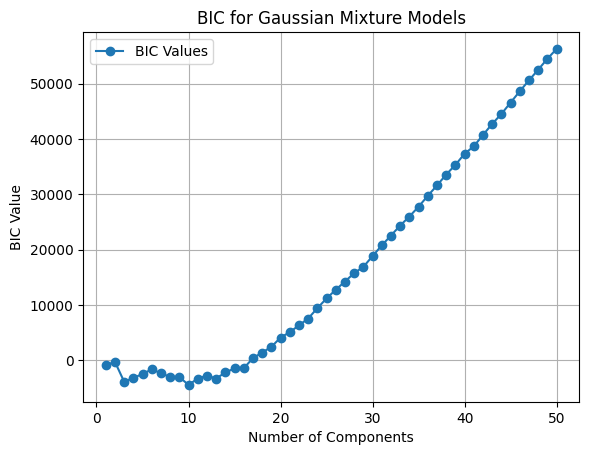

In [238]:
import matplotlib.pyplot as plt

def compute_bic(data, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models
    with different numbers of components.

    Parameters:
        data (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.

    Returns:
        list: BIC values for each number of components.
    """
    # List to store BIC values
    bic = []
    
    # Loop through number of components and compute BIC for each
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(data)  # Fit the model to the data
        bic.append(gmm.bic(data))  # Calculate BIC and add to list
    
    return bic  # Return list of BIC values

# Based on previous run
optimal_n_components = None

if optimal_n_components is None:
    # Range of number of components to evaluate
    n_components_range = range(1, 51)

    # Compute BIC values
    bic_values = compute_bic(simpleimputer_df, n_components_range)

    # Optimal number of components
    optimal_n_components = n_components_range[np.argmin(bic_values)]

    # Plotting BIC values
    plt.plot(n_components_range, bic_values, marker='o', label='BIC Values')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Value')
    plt.title('BIC for Gaussian Mixture Models')
    plt.grid(True)

    # Add legend
    plt.legend()
    plt.savefig('../images/with_missingness/BIC.png')
    plt.show()

In [239]:
# Create Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(cgmm_df)

GaussianMixture(n_components=10, random_state=404)

#### *Optional:* Can set all the values of a specific feature to -1 for the purpose of displaying it's distribution on the heatmap below

In [240]:
# Saving the values of a feature to mark them in the heatmap, e.g. CTA_CS
heatmap_feature = None
if heatmap_feature is not None:
    heatmap_feature_original_values = pd.Series(cgmm_df[heatmap_feature].copy().values, index=cgmm_df.index)

    # Get maximum and minimum values from the column
    heatmap_feature_max_value = cgmm_df[heatmap_feature].max()
    heatmap_feature_min_value = cgmm_df[heatmap_feature].min()

    cgmm_df[heatmap_feature] = -1
    # Check if the column exists
    if heatmap_feature + '_MISSING' in cgmm_df.columns:
        cgmm_df[heatmap_feature + '_MISSING'] = 1

#### Imputation

In [241]:
imputing_missing_data(cgmm_df, 'cgmm', model=gmm)

cgmm_df.head(5)

AGE  SEX_F                                           NIHSS_BL  \
818  0.303922    0.0                                           0.190476   
386  0.431373    1.0  {"samples": [-0.31524381379041455, -0.53634675...   
55   0.509804    0.0                                           0.142857   
902  0.735294    1.0  {"samples": [-0.7315852313588451, -0.952688171...   
264   0.72549    0.0                                           0.547619   

                                    SYS_BLOOD_PRESSURE PREV_MRS  \
818  {"samples": [-1.0016657990961741, -1.000748795...      0.0   
386                                              0.376      0.2   
55   {"samples": [-0.9982744485460736, -0.997892592...      0.0   
902                                              0.296      0.4   
264  {"samples": [-0.7804734338665369, -1.045969803...      0.8   

     ORAL_ANTICOAGULANT  HYPERTENSION  HYPERCHOL  ISCH_HEART SMOKING  ...  \
818                 0.0           0.0        1.0         1.0     0.0  ...   
386                 0.0           1.0        1.0         0.0     0.0  ...   
55                  0.0           0.0        0.0         0.0     0.0  ...   
902                 0.0           0.0        0.0         1.0     0.0  ...   
264                 0.0           0.0        1.0         1.0     0.0  ...   

                                          OCCLUSION_M2  \
818  {"samples": [-1.0011123474053099, -1.001195686...   
386  {"samples": [-1.0008707692830057, -1.000114448...   
55                                                 0.0   
902  {"samples": [-1.0008707692830057, -1.000114448...   
264                                                0.0   

                                         OCCLUSION_ICA  \
818  {"samples": [-1.000373297853332, -1.0001546974...   
386  {"samples": [-1.0007301356985485, -1.000001886...   
55                                                 0.0   
902  {"samples": [-1.0007301356985485, -1.000001886...   
264                                                0.0   

                                         OCCLUSION_ACA  \
818  {"samples": [-0.9999490947109876, -1.000451306...   
386  {"samples": [-0.9981080198765181, -1.001233437...   
55                                                 0.0   
902  {"samples": [-0.9981080198765181, -1.001233437...   
264                                                0.0   

                                         OCCLUSION_PCA  \
818  {"samples": [-1.0021645652569344, -0.998668804...   
386  {"samples": [-0.9998838439724798, -1.000301085...   
55                                                 1.0   
902  {"samples": [-0.9998838439724798, -1.000301085...   
264                                                0.0   

                                          OCCLUSION_VB  \
818  {"samples": [-1.0003162561726704, -0.999729340...   
386  {"samples": [-1.0002702386779756, -1.000557271...   
55                                                 0.0   
902  {"samples": [-1.0002702386779756, -1.000557271...   
264                                                0.0   

                                                CTA_CS  \
818  {"samples": [-1.0008273659925262, -1.000122652...   
386  {"samples": [-0.9995696813085702, -0.999748106...   
55   {"samples": [-1.0017890826935654, -1.001877843...   
902  {"samples": [-0.9995696813085702, -0.999748106...   
264                                           0.333333   

                                    ONSET_TO_ADMISSION  \
818                                           0.030556   
386  {"samples": [-0.9984345530637997, -0.999334724...   
55                                             0.08125   
902  {"samples": [-0.9984345530637997, -0.999334724...   
264                                           0.054167   

                                      ONSET_TO_IMAGING  \
818                                           0.041667   
386  {"samples": [-0.999836596351681, -0.9996932339...   
55                                            0.102083   
902  {"samples": [

#### Scoring

In [242]:
cgmm_score = get_scoring(cgmm_df, simpleimputer_df, 'cgmm')

#### *Optional:* Visualization via heatmap

In [243]:
if heatmap_feature is not None:
    # Define bin edges and adjust number of bins
    n_bins = 13
    h_min = heatmap_feature_min_value
    h_max = heatmap_feature_max_value
    width = (h_max - h_min) / (n_bins-1)
    bin_edges = np.arange(h_min - width/2, h_max +  width, width)

    # Save the original values of the heatmap feature
    heatmap_feature_values = cgmm_df[heatmap_feature]

    # Deserializing the values of the heatmap feature
    for i, entry in enumerate(heatmap_feature_values):
        if isinstance(entry, str):
            float_array = json.loads(entry)
            heatmap_feature_values[i] = float_array

    # Determine the number of samples based on the length of an entry with a list of values
    list_length = None
    for entry in heatmap_feature_values:
        if isinstance(entry, list):
            list_length = len(entry)
            break

    n_datapoints = cgmm_df.shape[0]
    histograms = []

    for entry in heatmap_feature_values:
        if isinstance(entry, list):
            # Apply np.histogram with specified bin edges
            hist, _ = np.histogram(entry, bins=bin_edges)
            histograms.append(hist)
        else:
            # Single-value entry: Place it in the correct bin and set frequency to list_length
            hist = np.zeros(len(bin_edges) - 1)
            row_index = np.digitize([entry], bin_edges)[0] - 1
            if 0 <= row_index < len(hist):
                hist[row_index] = list_length
            histograms.append(hist)

    # Reshape histograms to fit imshow format (histograms should be a 2D array)
    histograms_2d = np.array(histograms)

    # Determine figure height based on the number of datapoints
    fig_height = max(6, n_datapoints * 0.2)
    fig_width = min(max(10, bin_edges.shape[0] * 1), 32)

    extent = [bin_edges[0], bin_edges[-1], 0, len(histograms)]

    # Create heatmap
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(histograms_2d, aspect='auto', cmap='Reds', extent=extent)
    plt.colorbar()
    plt.xticks(bin_edges, labels=np.round(bin_edges, 2), rotation=90)
    plt.yticks(range(n_datapoints), range(n_datapoints))
    plt.xlabel('Values')
    plt.ylabel('Index')
    plt.title(heatmap_feature + ' values heatmap generated by cGMM')

    # Add markers for original values of a missing feature
    original_values = heatmap_feature_original_values[heatmap_feature_original_values != -1] # Selecting only the non -1 values
    indexes = heatmap_feature_original_values.index[heatmap_feature_original_values != -1] + 0.5 # Indexes corresponding to non -1 values
    plt.scatter(original_values, indexes, color='red', marker='o', s=80, label='Original Values')
    plt.scatter(simpleimputer_df[heatmap_feature], simpleimputer_df.index + 0.5, color='blue', marker='x', label='Imputer Values')

    plt.grid(True)
    plt.legend()
    plt.savefig('images/heatmaps/' + heatmap_feature + '_heatmap.png')
    plt.show()

#### Classification

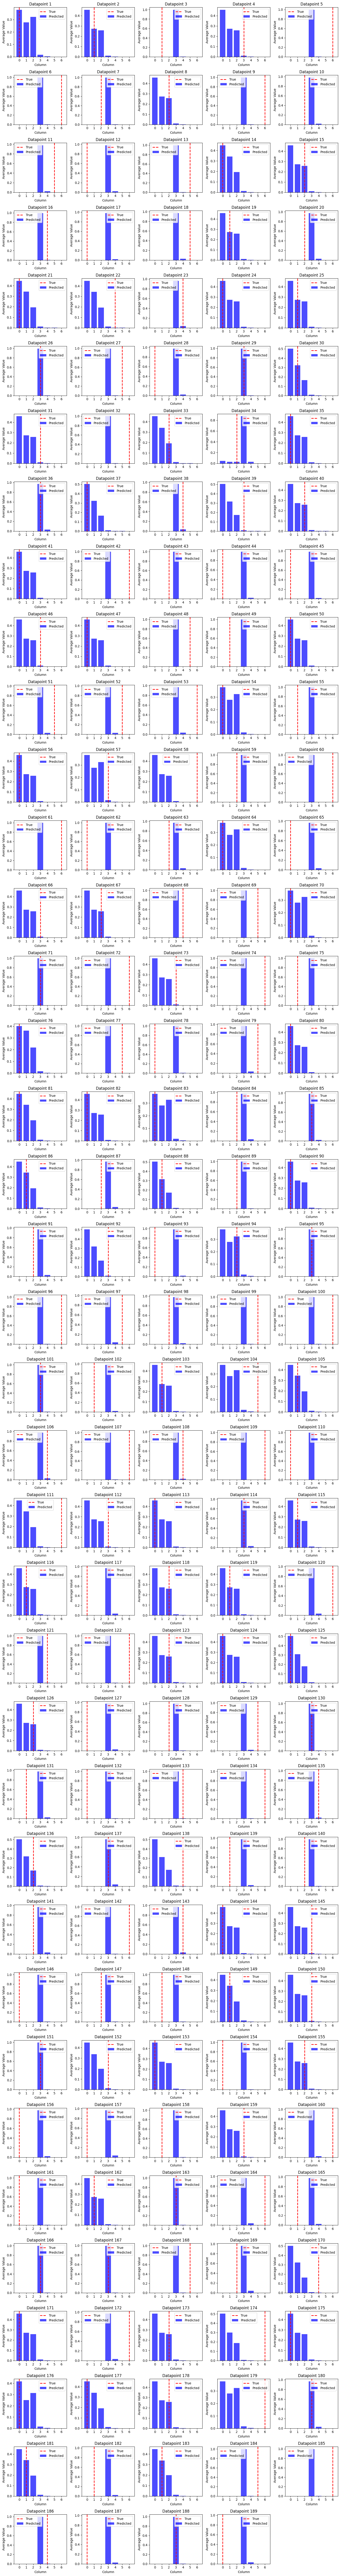

In [244]:
cgmm_prognosis = get_prognosis(cgmm_df, 'cgmm', True)

In [245]:
results_dict['cgmm'] = {'score': cgmm_score, 'prognosis': cgmm_prognosis}

## Variational Autoencoder with Arbitrary Conditioning

#### Preparation

In [246]:
vaeac_df = copy.deepcopy(X_test[simpleimputer_df.columns.tolist()])

In [247]:
from sklearn.decomposition import TruncatedSVD

# Perform Singular Value Decomposition (SVD) on training data
svd = TruncatedSVD(n_components=min(X_train.shape), random_state=RANDOM_STATE)
svd.fit(X_train)

# Calculate cumulative explained variance
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Choose threshold to preserve 90% of total variance
threshold_index = np.argmax(cumulative_variance_ratio >= 0.90)
threshold = svd.singular_values_[threshold_index]

print(f"Starting threshold to preserve 90% of total variance: {threshold}")

# Analyze singular values
singular_values = svd.singular_values_
num_non_trivial = np.sum(singular_values > threshold)  # Choose a threshold to determine non-trivial singular values

# Select latent space dimensionality
latent_dim = num_non_trivial

print(f"Number of non-trivial singular values: {num_non_trivial}")
print(f"Selected latent space dimensionality: {latent_dim}")

Starting threshold to preserve 90% of total variance: 10.346094941093792
Number of non-trivial singular values: 13
Selected latent space dimensionality: 13


In [248]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

input_dim = X_test[simpleimputer_df.columns.tolist()].shape[1]
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
z_mean = Dense(latent_dim)(encoded)
z_log_var = Dense(latent_dim)(encoded)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Define the decoder
decoded = z
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
outputs = Dense(input_dim)(decoded)

# Create the VAE model
vaeac = Model(inputs, outputs)

# Compile the model
vaeac.compile(optimizer='adam', loss='mse')  # Use MSE as the reconstruction loss

# Train the model
history = vaeac.fit(X_test[simpleimputer_df.columns.tolist()], X_test[simpleimputer_df.columns.tolist()], epochs=10, batch_size=32, verbose=1)

Epoch 1/10
6/6 [==============================] - 2s 6ms/step - loss: 0.5371
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.3905
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.3265
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2981
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2613
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2225
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.1955
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1827
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1712
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.1607


#### Imputation

In [249]:
imputing_missing_data(vaeac_df, 'vaeac', model=vaeac)

vaeac_df.head(5)

AGE  SEX_F                                           NIHSS_BL  \
818  0.303922    0.0                                           0.190476   
386  0.431373    1.0  {"samples": [-0.18072505295276642, -0.35023945...   
55   0.509804    0.0                                           0.142857   
902  0.735294    1.0  {"samples": [-0.11556154489517212, -0.23430433...   
264   0.72549    0.0                                           0.547619   

                                    SYS_BLOOD_PRESSURE PREV_MRS  \
818  {"samples": [-0.23613698780536652, -0.37308594...      0.0   
386                                              0.376      0.2   
55   {"samples": [-0.4333007037639618, -0.514780282...      0.0   
902                                              0.296      0.4   
264  {"samples": [-0.9775280356407166, -0.979275286...      0.8   

     ORAL_ANTICOAGULANT  HYPERTENSION  HYPERCHOL  ISCH_HEART SMOKING  ...  \
818                 0.0           0.0        1.0         1.0     0.0  ...   
386                 0.0           1.0        1.0         0.0     0.0  ...   
55                  0.0           0.0        0.0         0.0     0.0  ...   
902                 0.0           0.0        0.0         1.0     0.0  ...   
264                 0.0           0.0        1.0         1.0     0.0  ...   

                                          OCCLUSION_M2  \
818  {"samples": [-0.6288482546806335, -0.562720417...   
386  {"samples": [-1.127297282218933, -1.1990121603...   
55                                                 0.0   
902  {"samples": [-0.9797435998916626, -1.060243129...   
264                                                0.0   

                                         OCCLUSION_ICA  \
818  {"samples": [-0.7424951195716858, -0.730332851...   
386  {"samples": [-1.1453274488449097, -1.162690997...   
55                                                 0.0   
902  {"samples": [-0.9169307947158813, -1.137653112...   
264                                                0.0   

                                         OCCLUSION_ACA  \
818  {"samples": [-0.8684552311897278, -0.849701881...   
386  {"samples": [-1.138546347618103, -1.1098884344...   
55                                                 0.0   
902  {"samples": [-0.9611638784408569, -1.075909137...   
264                                                0.0   

                                         OCCLUSION_PCA  \
818  {"samples": [-0.777053713798523, -0.8513099551...   
386  {"samples": [-1.1701751947402954, -1.188599109...   
55                                                 1.0   
902  {"samples": [-1.0708612203598022, -1.112586975...   
264                                                0.0   

                                          OCCLUSION_VB  \
818  {"samples": [-0.7711986303329468, -0.762928843...   
386  {"samples": [-1.1173453330993652, -1.201433300...   
55                                                 0.0   
902  {"samples": [-1.024161458015442, -1.0924923419...   
264                                                0.0   

                                                CTA_CS  \
818  {"samples": [-0.9037211537361145, -0.965865135...   
386  {"samples": [-1.221217393875122, -1.2539218664...   
55   {"samples": [-0.2795526385307312, -0.107462532...   
902  {"samples": [-1.069040060043335, -1.1636908054...   
264                                           0.333333   

                                    ONSET_TO_ADMISSION  \
818                                           0.030556   
386  {"samples": [-0.9828174710273743, -0.947729647...   
55                                             0.08125   
902  {"samples": [-0.9203819632530212, -0.951524853...   
264                                           0.054167   

                                      ONSET_TO_IMAGING  \
818                                           0.041667   
386  {"samples": [-0.8673216104507446, -0.917064964...   
55                                            0.102083   
902  {"samples": [

#### Scoring

In [250]:
vaeac_score = get_scoring(vaeac_df, simpleimputer_df, 'vaeac')

#### Classification

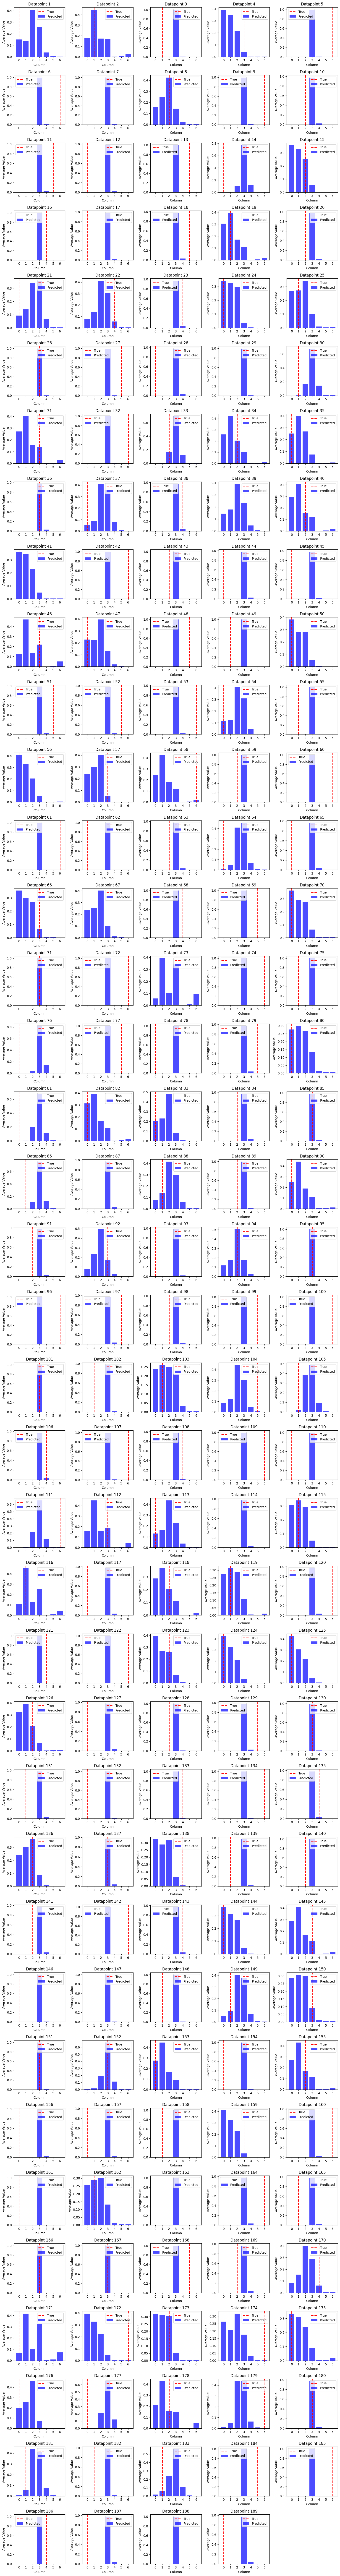

In [251]:
vaeac_prognosis = get_prognosis(vaeac_df, 'vaeac', True)

In [252]:
results_dict['vaeac'] = {'score': vaeac_score, 'prognosis': vaeac_prognosis}

## Generative Adversarial Imputation Network

#### Preparation

In [253]:
gain_df = copy.deepcopy(X_test[simpleimputer_df.columns.tolist()])

In [254]:
from joblib import load

gain = load('..\helpers\generative_models\had_gain_generator.h5')

#### Imputation

In [255]:
imputing_missing_data(gain_df, 'gain', model=gain)

gain_df.head(5)

AGE  SEX_F                                           NIHSS_BL  \
818  0.303922    0.0                                           0.190476   
386  0.431373    1.0  {"samples": [2.280993612657767e-06, 2.28099361...   
55   0.509804    0.0                                           0.142857   
902  0.735294    1.0  {"samples": [2.080448894048459e-06, 2.08044889...   
264   0.72549    0.0                                           0.547619   

                                    SYS_BLOOD_PRESSURE PREV_MRS  \
818  {"samples": [5.374718057282735e-07, 5.37471805...      0.0   
386                                              0.376      0.2   
55   {"samples": [2.5470193577348255e-05, 2.5470193...      0.0   
902                                              0.296      0.4   
264  {"samples": [8.182531132661097e-07, 8.18253113...      0.8   

     ORAL_ANTICOAGULANT  HYPERTENSION  HYPERCHOL  ISCH_HEART SMOKING  ...  \
818                 0.0           0.0        1.0         1.0     0.0  ...   
386                 0.0           1.0        1.0         0.0     0.0  ...   
55                  0.0           0.0        0.0         0.0     0.0  ...   
902                 0.0           0.0        0.0         1.0     0.0  ...   
264                 0.0           0.0        1.0         1.0     0.0  ...   

                                          OCCLUSION_M2  \
818  {"samples": [1.0006609727497562e-06, 1.0006609...   
386  {"samples": [2.5116634105870617e-07, 2.5116634...   
55                                                 0.0   
902  {"samples": [2.869337265565264e-07, 2.86933726...   
264                                                0.0   

                                         OCCLUSION_ICA  \
818  {"samples": [4.594716756400885e-06, 4.59471675...   
386  {"samples": [1.384528559356113e-06, 1.38452855...   
55                                                 0.0   
902  {"samples": [8.206984603020828e-07, 8.20698460...   
264                                                0.0   

                                         OCCLUSION_ACA  \
818  {"samples": [6.666158469670336e-07, 6.66615846...   
386  {"samples": [1.0643971393164975e-07, 1.0643971...   
55                                                 0.0   
902  {"samples": [8.231710069139808e-08, 8.23171006...   
264                                                0.0   

                                         OCCLUSION_PCA  \
818  {"samples": [7.605843279634428e-07, 7.60584327...   
386  {"samples": [1.5110356343939202e-07, 1.5110356...   
55                                                 1.0   
902  {"samples": [1.450204081265838e-07, 1.45020408...   
264                                                0.0   

                                          OCCLUSION_VB  \
818  {"samples": [2.2436606741393916e-06, 2.2436606...   
386  {"samples": [8.3661956296055e-07, 8.3661956296...   
55                                                 0.0   
902  {"samples": [4.553401709017635e-07, 4.55340170...   
264                                                0.0   

                                                CTA_CS  \
818  {"samples": [5.086525561637245e-06, 5.08652556...   
386  {"samples": [1.7718466551741585e-06, 1.7718466...   
55   {"samples": [4.240531416144222e-05, 4.24053141...   
902  {"samples": [1.3051684391029994e-06, 1.3051684...   
264                                           0.333333   

                                    ONSET_TO_ADMISSION  \
818                                           0.030556   
386  {"samples": [5.936433922215656e-07, 5.93643392...   
55                                             0.08125   
902  {"samples": [5.711925723517197e-07, 5.71192572...   
264                                           0.054167   

                                      ONSET_TO_IMAGING  \
818                                           0.041667   
386  {"samples": [4.866733434027992e-07, 4.86673343...   
55                                            0.102083   
902  {"samples": [

#### Scoring

In [256]:
gain_score = get_scoring(gain_df, simpleimputer_df, 'gain')

#### Classification

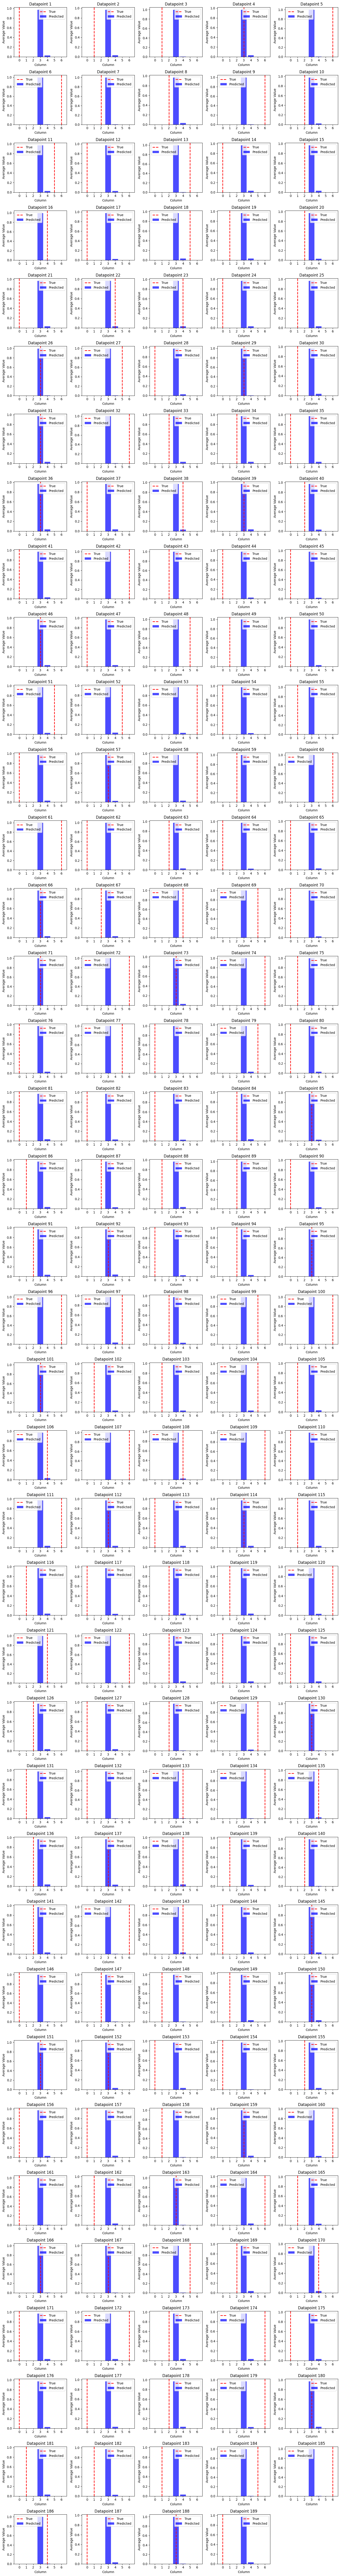

In [257]:
gain_prognosis = get_prognosis(gain_df, 'gain', True)

In [258]:
results_dict['gain'] = {'score': gain_score, 'prognosis': gain_prognosis}

## Comparison of results

multivariate prognosis: 


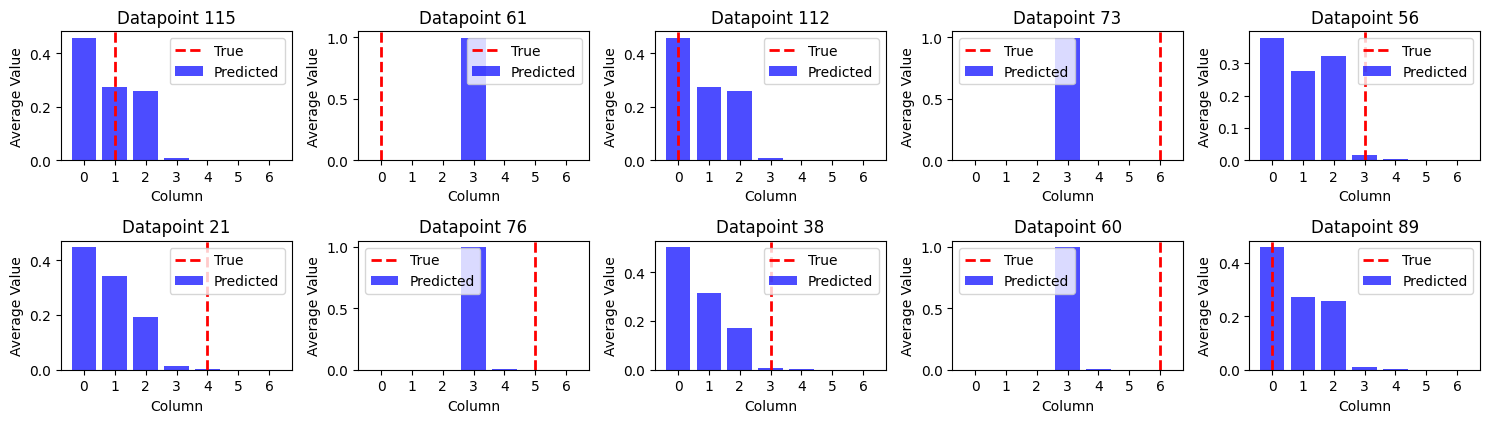

cgmm prognosis: 


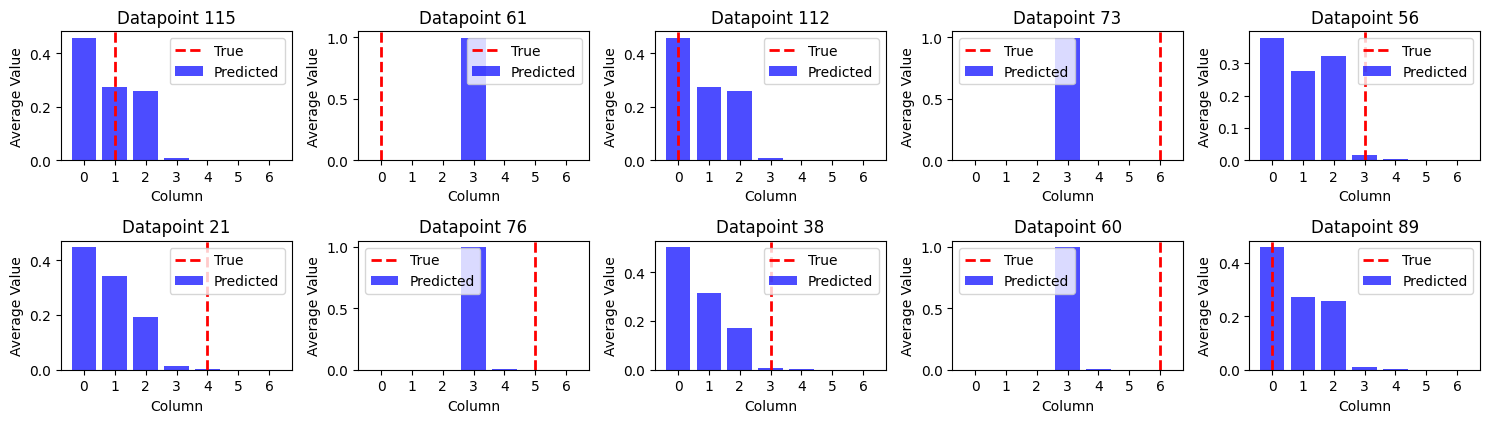

vaeac prognosis: 


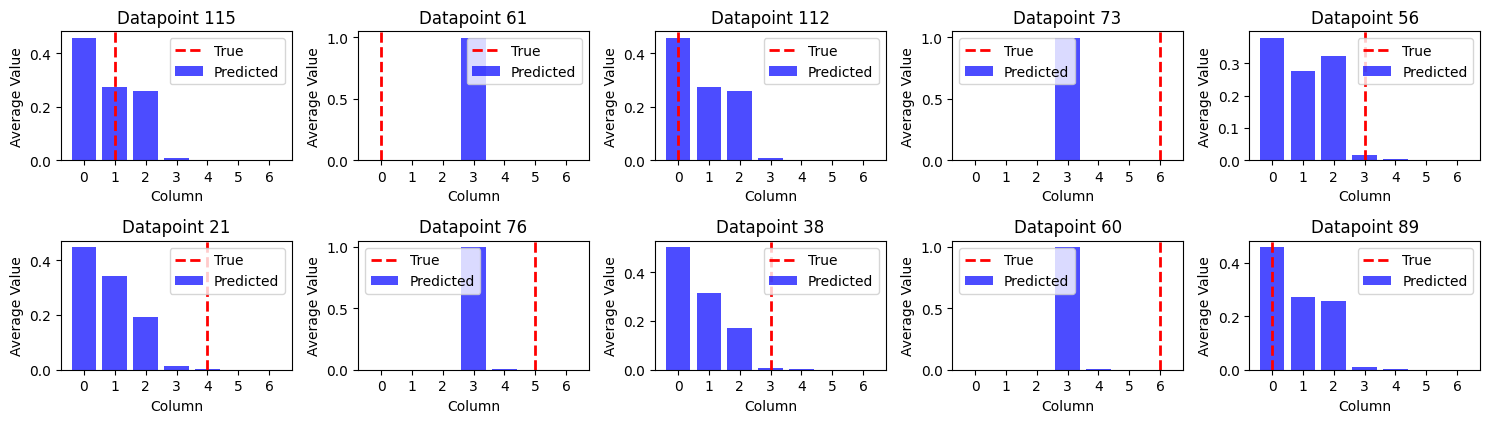

gain prognosis: 


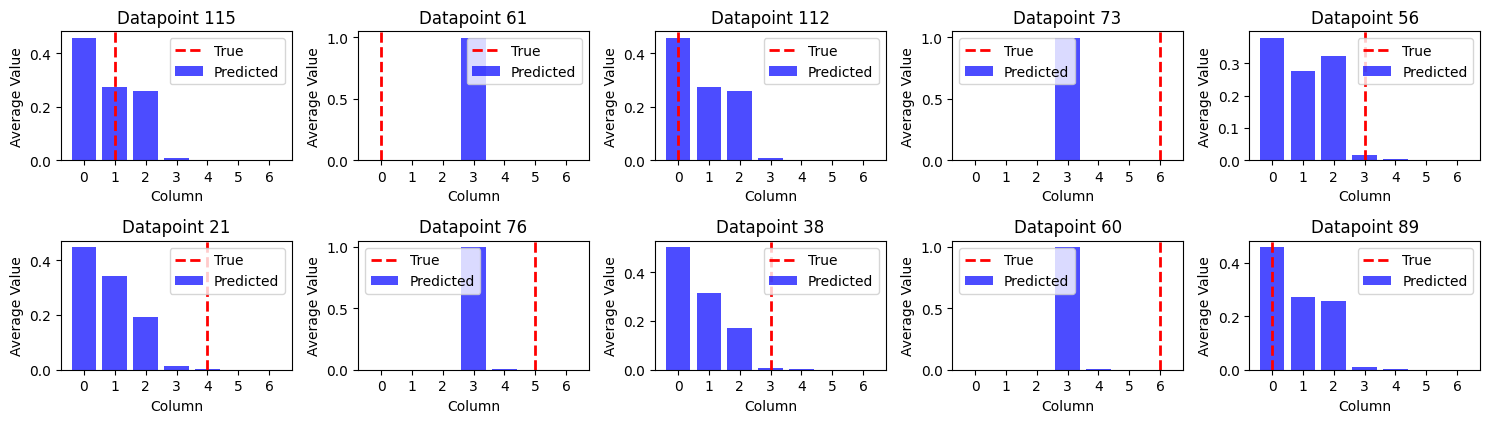

In [382]:
from operator import itemgetter

random_indices = np.random.choice(len(y_test), 10)

# Display prognosis for each model
for key, value in results_dict.items():
    print(f"{key} prognosis: ")
    visualize_prognosis(y_test[random_indices], itemgetter(*random_indices)(results_dict['cgmm']['prognosis']), random_indices)